**Team 4**: Brendan Wilcox, Mohammed Zaid Bin Haris, Nimisha Agarwal, Quan Nguyen

Notebook Link: https://colab.research.google.com/drive/1WbTVjyd5M5yKvj-KHM_2goayqLI4CWP4?usp=sharing

# Introduction

## Motivation

The Iowa liquor market is a diverse and competitive landscape, influenced by regional preferences, seasonal trends, and consumer behavior. For new sellers, entering this market requires a clear understanding of its unique dynamics to establish a strong presence. With the right insights, sellers can align their operations with local demand patterns, ensuring they remain competitive and responsive to customer needs. This project is motivated by the opportunity to empower new entrants with data-driven tools to navigate the complexities of this market and succeed in their business goals.

## Problem Statement

New liquor sellers entering the Iowa market face significant challenges in predicting demand and managing inventory effectively. Without reliable forecasts, they risk overstocking, which increases costs, or stockouts, which lead to lost sales and dissatisfied customers. This project addresses these challenges by analyzing historical sales data to build predictive models that forecast weekly and monthly sales. These tools provide actionable insights to help sellers optimize inventory planning and distribution, enabling them to overcome initial hurdles and operate efficiently in a new market.

# Data

## Data Source

We will use the Iowa Liquor Sales dataset from Iowa’s Alcoholic Beverages Division, accessible via data.iowa.gov. We are accessing the data set from Big Query Public Datasets. This dataset offers detailed records of liquor sales by Iowa Class "E" license holders, including grocery stores, liquor stores, and convenience stores, from January 1, 2012, to the present.

## Loading the Dataset

In [1]:
#Installation

!pip install xgboost
!pip install scikit-optimize

In [2]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import dateutil.parser as dp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import ElasticNetCV
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error

In [3]:
from google.cloud import bigquery

client = bigquery.Client()

In [4]:
#Querying Dataset & Saving Into DataFrame
sql = """
SELECT * FROM `bigquery-public-data.iowa_liquor_sales.sales`
"""
iowa_df = client.query(sql).to_dataframe()

## About the Dataset

In [5]:
iowa_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S11404500002,2013-04-03,4474,BUCKY'S EXPRESS #34 / COUNCIL BLUFFS,3501 W BROADWAY ST,COUNCIL BLUFFS,51501,POINT(-95.902733 41.261916),78,POTTAWATTAMIE,...,58835,JOSE CUERVO AUTHENTIC LIME MARGARITA,6,800,4.62,6.92,6,41.52,4.8,1.27
1,INV-38247300033,2021-07-12,5663,LAKE VIEW REDEMPTION & LIQUOR STORE,502 5TH ST,LAKE VIEW,51450.0,POINT(-95.051539 42.307764),81,SAC,...,73053,RUMCHATA,6,1000,17.00,25.50,6,153.00,6.0,1.58
2,INV-51808800026,2022-10-05,2536,HY-VEE / PLEASANT HILL,4815 MAPLE DRIVE,PLEASANT HILL,50317.0,POINT(-93.519491 41.598133),None,POLK,...,11296,CROWN ROYAL,12,750,17.49,26.24,48,1259.52,36.0,9.51
3,INV-40354400041,2021-09-23,2106,HILLSTREET NEWS AND TOBACCO,2217 COLLEGE,CEDAR FALLS,50613.0,POINT(-92.455796 42.517182),7,BLACK HAWK,...,86251,JUAREZ TRIPLE SEC,12,1000,2.42,3.63,36,130.68,36.0,9.51
4,INV-37858700002,2021-06-28,2635,HY-VEE #4 / DAVENPORT,4064 E 53RD ST,DAVENPORT,52807.0,POINT(-90.513769 41.574973),82,SCOTT,...,38176,TITOS HANDMADE VODKA,12,750,10.00,15.00,300,4500.00,225.0,59.43


In [6]:
iowa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30522849 entries, 0 to 30522848
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   invoice_and_item_number  object 
 1   date                     dbdate 
 2   store_number             object 
 3   store_name               object 
 4   address                  object 
 5   city                     object 
 6   zip_code                 object 
 7   store_location           object 
 8   county_number            object 
 9   county                   object 
 10  category                 object 
 11  category_name            object 
 12  vendor_number            object 
 13  vendor_name              object 
 14  item_number              object 
 15  item_description         object 
 16  pack                     Int64  
 17  bottle_volume_ml         Int64  
 18  state_bottle_cost        float64
 19  state_bottle_retail      float64
 20  bottles_sold             Int64  
 21  sale_d

In [7]:
iowa_df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,3.052285e+07,3.052285e+07,3.052284e+07,3.052284e+07,3.052285e+07,3.052284e+07,3.052285e+07,3.052285e+07
mean,1.211353e+01,8.733166e+02,1.083538e+01,1.626282e+01,1.088916e+01,1.464908e+02,9.149059e+00,2.414037e+00
std,7.801286e+00,6.214242e+02,1.346843e+01,2.020139e+01,3.071602e+01,5.179991e+02,3.647156e+01,9.634879e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.680000e+02,-9.720000e+03,-1.344000e+03,-3.550400e+02
25%,6.000000e+00,7.500000e+02,5.750000e+00,8.630000e+00,3.000000e+00,3.600000e+01,1.500000e+00,4.000000e-01
50%,1.200000e+01,7.500000e+02,8.500000e+00,1.275000e+01,6.000000e+00,7.776000e+01,4.800000e+00,1.260000e+00
75%,1.200000e+01,1.000000e+03,1.300000e+01,1.950000e+01,1.200000e+01,1.501200e+02,1.050000e+01,2.770000e+00
max,3.360000e+02,3.780000e+05,2.498902e+04,3.748353e+04,1.500000e+04,2.795573e+05,1.500000e+04,3.962580e+03


#### Summary

The Iowa Liquor Sales dataset contains approximately 30 million records with 24 columns. Key features include:

- **Store Information**: Fields such as store ID, name, address, city, and county, which will allow us to analyze geographic differences in demand.

- **Product Information**: Details such as product ID, description, category, vendor, and bottle volume, enabling the categorization of products for a more targeted analysis.

- **Sales Data**: Key metrics like order date, number of bottles sold, retail price, total sales amount, and volume sold in liters/gallons, which are essential for forecasting sales trends.

The dataset contains a mixture of text (store and product descriptions), numeric (sales figures, bottle costs), and datetime (order dates) variables, making it well-suited for both time-series and categorical analyses.


# Exploratory Data Analysis

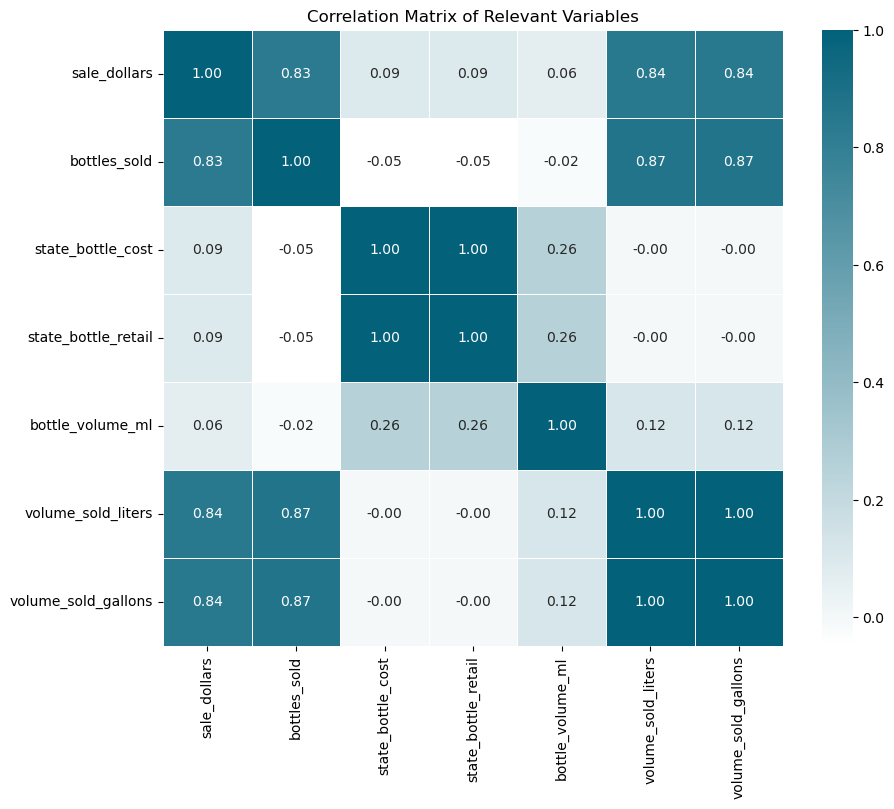

In [8]:
# Define a custom colormap using #03617A
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#FFFFFF", "#03617A"])

# Generate the correlation matrix
relevant_columns = [
    'sale_dollars', 
    'bottles_sold', 
    'state_bottle_cost', 
    'state_bottle_retail', 
    'bottle_volume_ml', 
    'volume_sold_liters', 
    'volume_sold_gallons'
]
correlation_matrix = iowa_df[relevant_columns].corr()

# Plot the heatmap with the custom colormap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap=custom_cmap, 
    fmt=".2f", 
    linewidths=0.5
)
plt.title("Correlation Matrix of Relevant Variables")
plt.show()

### **Insights**
The correlation matrix shows strong positive correlations between sale_dollars, bottles_sold, volume_sold_liters, and volume_sold_gallons, suggesting that higher sales are associated with larger quantities sold. Meanwhile, state_bottle_cost and state_bottle_retail have minimal correlation with other variables, indicating that price per bottle does not strongly influence total sales volume.

It is intutitive that there would be strong positive correlations between sale_dollars, bottles_sold, volume_sold_liters, and volume_sold_gallons, as they are the main inputs in the Price * Quantity = Revenue equation. Because of this, creating a correlation matrix of these variables was not about finding unexpected insights, but about performing a sanity check to make sure that our data made sense before proceeding withing further analysis.

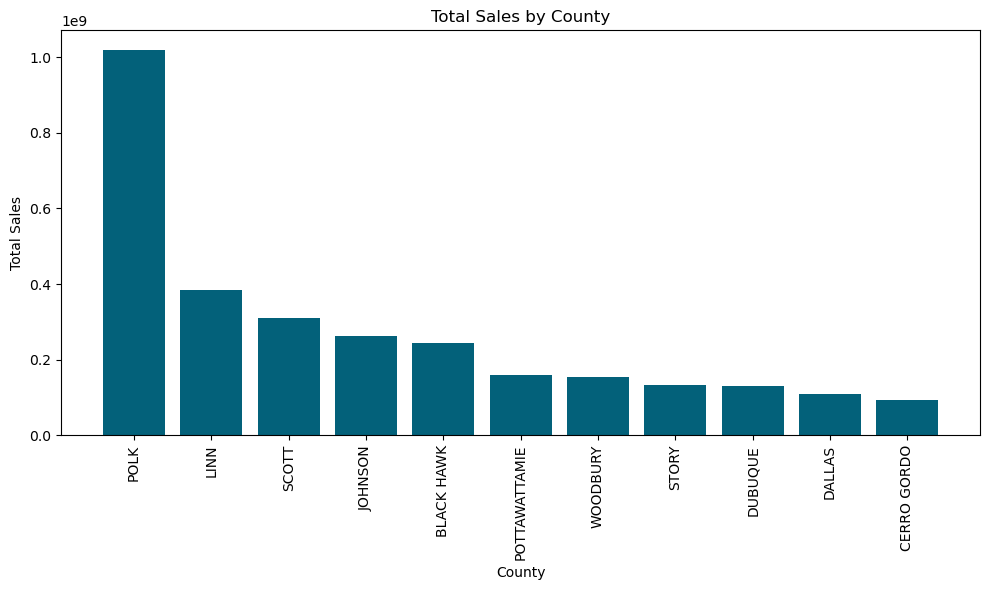

In [10]:
# Group by county and calculate total sales
groupby_county = iowa_df.groupby('county')
sum_sales = groupby_county['sale_dollars'].sum().sort_values(ascending=False)
top10_sum_sales = sum_sales[0:11]

# Plot the bar chart with custom bar color
plt.figure(figsize=(10, 6))
plt.bar(top10_sum_sales.index, top10_sum_sales.values, color='#03617A')
plt.xlabel('County')
plt.ylabel('Total Sales')
plt.title('Total Sales by County')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### **Insights**
This chart displays the top 10 counties by total liquor sales, with Polk County significantly outpacing the others. Linn and Scott counties follow, but there is a steep drop in sales after Polk, highlighting its dominance in liquor sales among the top counties.

This graph is interesting to us because it shows that georgraphy will play a factor in our sales forecast. With that, we will need to consider "county" as a variable in our model and pay attention to other categorical variables in general as we continue our analysis.

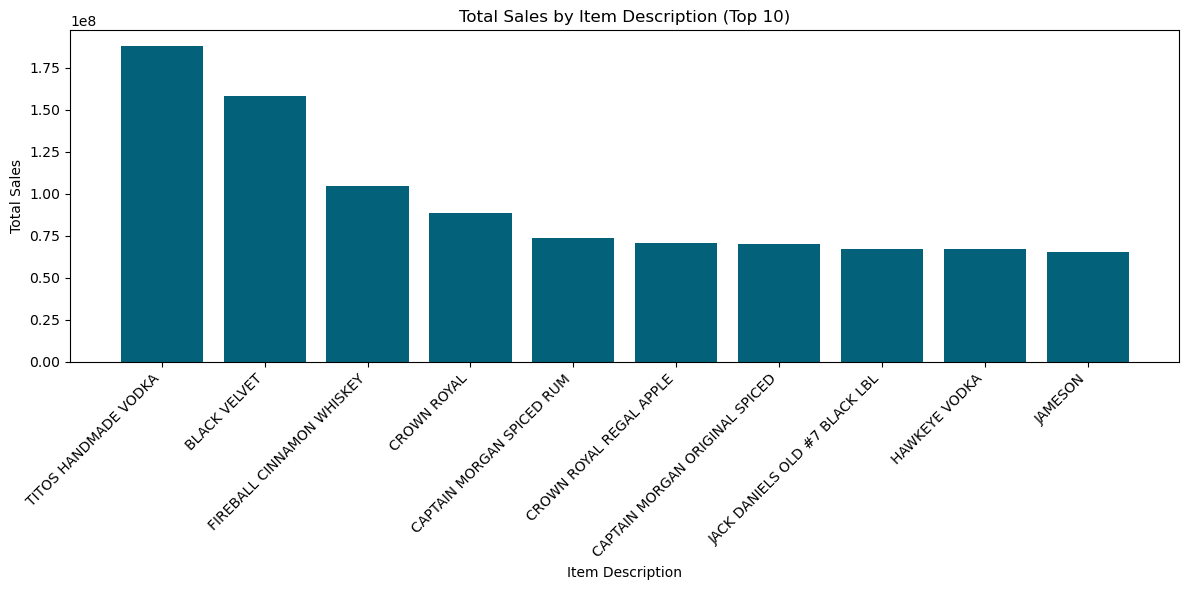

In [11]:
# Group by item_description and calculate total sales
groupby_item = iowa_df.groupby('item_description')
sum_sales_item = groupby_item['sale_dollars'].sum().sort_values(ascending=False)
top10_sales_item = sum_sales_item[:10] 

# Plot the bar chart with custom bar color
plt.figure(figsize=(12, 6))
plt.bar(top10_sales_item.index, top10_sales_item.values, color='#03617A')
plt.xlabel('Item Description')
plt.ylabel('Total Sales')
plt.title('Total Sales by Item Description (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  
plt.show()

### **Insights**

This chart highlights the top 10 liquor items by total sales, with "Tito's Handmade Vodka" leading significantly, followed by "Black Velvet" and "Fireball Cinnamon Whiskey."

This is important as it emphasizes the dominance of specific products in consumer demand, making "item description" a critical variable for forecasting and inventory planning.

# Data Cleaning

In [12]:
# Filtering data for required time period (2021-07-01 to 2024-10-31)
iowa_df['date'] = pd.to_datetime(iowa_df['date'])

iowa_cleaned = iowa_df[(iowa_df['date'] >= '2021-07-01') & (iowa_df['date'] <= '2024-10-31')]



# Drop any rows with negative values
num_columns_to_check = [
    'pack', 
    'bottle_volume_ml', 
    'state_bottle_cost', 
    'state_bottle_retail', 
    'bottles_sold', 
    'sale_dollars', 
    'volume_sold_liters', 
    'volume_sold_gallons'
]

iowa_cleaned = iowa_cleaned[(iowa_cleaned[num_columns_to_check] >= 0).all(axis=1)]


# Repeat to Sanity Check during Cleaning
iowa_cleaned.info()
iowa_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8657373 entries, 1 to 30521570
Data columns (total 24 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   invoice_and_item_number  object        
 1   date                     datetime64[ns]
 2   store_number             object        
 3   store_name               object        
 4   address                  object        
 5   city                     object        
 6   zip_code                 object        
 7   store_location           object        
 8   county_number            object        
 9   county                   object        
 10  category                 object        
 11  category_name            object        
 12  vendor_number            object        
 13  vendor_name              object        
 14  item_number              object        
 15  item_description         object        
 16  pack                     Int64         
 17  bottle_volume_ml         I

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1,INV-38247300033,2021-07-12,5663,LAKE VIEW REDEMPTION & LIQUOR STORE,502 5TH ST,LAKE VIEW,51450.0,POINT(-95.051539 42.307764),81,SAC,...,73053,RUMCHATA,6,1000,17.00,25.50,6,153.00,6.0,1.58
2,INV-51808800026,2022-10-05,2536,HY-VEE / PLEASANT HILL,4815 MAPLE DRIVE,PLEASANT HILL,50317.0,POINT(-93.519491 41.598133),None,POLK,...,11296,CROWN ROYAL,12,750,17.49,26.24,48,1259.52,36.0,9.51
3,INV-40354400041,2021-09-23,2106,HILLSTREET NEWS AND TOBACCO,2217 COLLEGE,CEDAR FALLS,50613.0,POINT(-92.455796 42.517182),7,BLACK HAWK,...,86251,JUAREZ TRIPLE SEC,12,1000,2.42,3.63,36,130.68,36.0,9.51
6,INV-48872900037,2022-07-01,6130,HIWAY 20 LIQUOR AND TOBACCO / FORT DODGE,1724 5TH AVE S,FORT DODGE,50501,POINT(-94.173816 42.501131),94,WEBSTER,...,35913,FIVE O'CLOCK VODKA,48,200,1.15,1.73,48,83.04,9.6,2.53
8,INV-61060600028,2023-08-08,5870,KEYSTONE LIQUOR,517 2ND ST,CORALVILLE,52241.0,POINT(-91.573721641 41.671941938),None,JOHNSON,...,75208,KINKY PINK MINI,6,50,4.84,7.26,6,43.56,0.3,0.07


**Initial Adjustments**

From the start, we faced computing limitations due to our dataset having 30,522,849 rows. This forced us to utilize a VM instance in GoogleCloud that provided more computing power than offered by Google Colab. 

Even then, that large number of rows could not be handled effectively by the still-limited VM, prompting us to shrink the date range from 01/03/2012 - 10/31/2024 to 07/01/2021 - 10/31/2024. This reduction made the dataset more workable and allowed us to focus on recent trends without the influence of the abnormal dynamics created by the COVID-19 Pandemic (07/01/2021 is widely considered the marker for a complete return to normalcy).

In the same code block, we removed any rows with negative (-) values we noticed during our initial exploration. Research led us to the conclusion that these negative values represented inventory adjustments and or returns. Despite this explanation, given the size of the dataset and our goal of projecting sales alone, we decided to remove any rows that had negatives in key numerical columns. This initial cleaning effort reduced the dataset to 8,657,373 rows

In [13]:
iowa_cleaned = iowa_cleaned.drop(columns=['store_location', 'county_number'])

null_counts = iowa_cleaned.isnull().sum()

print("Count of nulls in each column:")
print(null_counts)

Count of nulls in each column:
invoice_and_item_number       0
date                          0
store_number                  0
store_name                    0
address                    3344
city                       3344
zip_code                   3366
county                     3344
category                      0
category_name                 0
vendor_number                 0
vendor_name                   0
item_number                   0
item_description              0
pack                          0
bottle_volume_ml              0
state_bottle_cost             0
state_bottle_retail           0
bottles_sold                  0
sale_dollars                  0
volume_sold_liters            0
volume_sold_gallons           0
dtype: int64


In [14]:
iowa_cleaned = iowa_cleaned.dropna()

null_counts = iowa_cleaned.isnull().sum()

print("Count of nulls in each column:")
print(null_counts)
iowa_cleaned.info()
iowa_cleaned.head()

Count of nulls in each column:
invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8654007 entries, 1 to 30521570
Data columns (total 22 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   invoice_and_item_number  object        
 1   date                     datetime64[ns]
 2   store_number       

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county,category,category_name,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1,INV-38247300033,2021-07-12,5663,LAKE VIEW REDEMPTION & LIQUOR STORE,502 5TH ST,LAKE VIEW,51450.0,SAC,1081200.0,CREAM LIQUEURS,...,73053,RUMCHATA,6,1000,17.00,25.50,6,153.00,6.0,1.58
2,INV-51808800026,2022-10-05,2536,HY-VEE / PLEASANT HILL,4815 MAPLE DRIVE,PLEASANT HILL,50317.0,POLK,1012100.0,CANADIAN WHISKIES,...,11296,CROWN ROYAL,12,750,17.49,26.24,48,1259.52,36.0,9.51
3,INV-40354400041,2021-09-23,2106,HILLSTREET NEWS AND TOBACCO,2217 COLLEGE,CEDAR FALLS,50613.0,BLACK HAWK,1081500.0,TRIPLE SEC,...,86251,JUAREZ TRIPLE SEC,12,1000,2.42,3.63,36,130.68,36.0,9.51
6,INV-48872900037,2022-07-01,6130,HIWAY 20 LIQUOR AND TOBACCO / FORT DODGE,1724 5TH AVE S,FORT DODGE,50501,WEBSTER,1031100.0,AMERICAN VODKAS,...,35913,FIVE O'CLOCK VODKA,48,200,1.15,1.73,48,83.04,9.6,2.53
8,INV-61060600028,2023-08-08,5870,KEYSTONE LIQUOR,517 2ND ST,CORALVILLE,52241.0,JOHNSON,1081300.0,AMERICAN CORDIALS & LIQUEURS,...,75208,KINKY PINK MINI,6,50,4.84,7.26,6,43.56,0.3,0.07


**Handling nulls**

In our first assessment of nulls, we saw that the “store_location” and “county_number” columns were missing  423,768 and 6,008,891 values, respectively. Given that “store_location” provided coordinates of the store being sold to, this information was too granular for the model we aimed to create as we aimed to generalize for areas, not exact store locations. Additionally, including these coordinates could cause the model to overfit to specific stores. Thus, instead of predicting sales volume based on the feature set, it would be doing so based on trends associated with a specific location. Further, since the dataset included “county,” “county_number” was unnecessary as “county” (The string name of the county) provided better real-world application and had no nulls. Ultimately, we could drop both columns without impeding our model.

With the two primary “problematic” columns gone, we turned our attention to “address,” “city,” and “county” with 3,344 nulls each, as well as “zip_code” with 3,366 nulls. Given that each value amounted to ~0.04% of the dataset, we decided to drop all remaining null rows instead of imputing any values. The impact of these rows representing individual sales would be minuscule on the model, making it not worth any effort to impute the values (Even if all of these nulls were in different rows, they would still only represent ~0.15% of the dataset).

In [15]:
iowa_cleaned_ml = iowa_cleaned

In [16]:
iowa_cleaned_ml.drop(columns=['invoice_and_item_number', 'store_number', 'store_name', 'address', 
                                 'category', 'item_number','bottles_sold', 'sale_dollars', 'volume_sold_gallons'], inplace=True)
                     
iowa_cleaned_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8654007 entries, 1 to 30521570
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   city                 object        
 2   zip_code             object        
 3   county               object        
 4   category_name        object        
 5   vendor_number        object        
 6   vendor_name          object        
 7   item_description     object        
 8   pack                 Int64         
 9   bottle_volume_ml     Int64         
 10  state_bottle_cost    float64       
 11  state_bottle_retail  float64       
 12  volume_sold_liters   float64       
dtypes: Int64(2), datetime64[ns](1), float64(3), object(7)
memory usage: 940.9+ MB


In [17]:
iowa_cleaned_ml['date'] = pd.to_datetime(iowa_cleaned_ml['date'])

iowa_cleaned_ml['date'] = iowa_cleaned_ml['date'].dt.year

In [18]:
# Renaming the 'date' column to 'year'

iowa_cleaned_ml.rename(columns={'date': 'year'}, inplace=True)
iowa_cleaned_ml.head()

,year,city,zip_code,county,category_name,vendor_number,vendor_name,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,volume_sold_liters
1,2021,LAKE VIEW,51450.0,SAC,CREAM LIQUEURS,205,E & J GALLO WINERY,RUMCHATA,6,1000,17.00,25.50,6.0
2,2022,PLEASANT HILL,50317.0,POLK,CANADIAN WHISKIES,260,DIAGEO AMERICAS,CROWN ROYAL,12,750,17.49,26.24,36.0
3,2021,CEDAR FALLS,50613.0,BLACK HAWK,TRIPLE SEC,434,LUXCO INC,JUAREZ TRIPLE SEC,12,1000,2.42,3.63,36.0
6,2022,FORT DODGE,50501,WEBSTER,AMERICAN VODKAS,297,LAIRD & COMPANY,FIVE O'CLOCK VODKA,48,200,1.15,1.73,9.6
8,2023,CORALVILLE,52241.0,JOHNSON,AMERICAN CORDIALS & LIQUEURS,772,INTERCONTINENTAL PACKAGING COMPANY/PRESTIGE BE...,KINKY PINK MINI,6,50,4.84,7.26,0.3


In [19]:
unique_vendor_count = iowa_cleaned_ml['vendor_name'].nunique()
print(f"Number of unique vendor names: {unique_vendor_count}")

Number of unique vendor names: 335


In [20]:
# Group by 'vendor_name', 'year', and 'item_description'
iowa_eda = iowa_cleaned_ml.groupby(['vendor_name', 'year', 'item_description']).agg(
    city=('city', 'first'),
    zip_code=('zip_code', 'first'),
    county=('county', 'first'),
    category_name=('category_name', 'first'),
    vendor_number=('vendor_number', 'first'),
    pack_avg=('pack', 'mean'),
    bottle_volume_ml_avg=('bottle_volume_ml', 'mean'),
    state_bottle_cost_avg=('state_bottle_cost', 'mean'),
    state_bottle_retail_avg=('state_bottle_retail', 'mean'),
    volume_sold_liters_total=('volume_sold_liters', 'sum')
).reset_index()

iowa_eda.info()
iowa_eda.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16316 entries, 0 to 16315
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vendor_name               16316 non-null  object 
 1   year                      16316 non-null  int64  
 2   item_description          16316 non-null  object 
 3   city                      16316 non-null  object 
 4   zip_code                  16316 non-null  object 
 5   county                    16316 non-null  object 
 6   category_name             16316 non-null  object 
 7   vendor_number             16316 non-null  object 
 8   pack_avg                  16316 non-null  Float64
 9   bottle_volume_ml_avg      16316 non-null  Float64
 10  state_bottle_cost_avg     16316 non-null  float64
 11  state_bottle_retail_avg   16316 non-null  float64
 12  volume_sold_liters_total  16316 non-null  float64
dtypes: Float64(2), float64(3), int64(1), object(7)
memory usage: 

,vendor_name,year,item_description,city,zip_code,county,category_name,vendor_number,pack_avg,bottle_volume_ml_avg,state_bottle_cost_avg,state_bottle_retail_avg,volume_sold_liters_total
0,10TH MOUNTAIN WHISKEY AND SPIRIT COMPANY,2023,10TH MOUNTAIN BOURBON,WATERLOO,50702.0,BLACK HAWK,STRAIGHT BOURBON WHISKIES,522,6.0,750.0,34.50,51.75,90.00
1,10TH MOUNTAIN WHISKEY AND SPIRIT COMPANY,2023,10TH MOUNTAIN CORDIAL,DAVENPORT,52807.0,SCOTT,AMERICAN CORDIALS & LIQUEURS,522,6.0,750.0,25.00,37.50,49.50
2,10TH MOUNTAIN WHISKEY AND SPIRIT COMPANY,2023,10TH MOUNTAIN RYE,OSKALOOSA,52577.0,MAHASKA,STRAIGHT RYE WHISKIES,522,6.0,750.0,27.00,40.50,29.25
3,10TH MOUNTAIN WHISKEY AND SPIRIT COMPANY,2024,10TH MOUNTAIN AMERICAN SINGLE MALT,CEDAR RAPIDS,52402.0,LINN,AMERICAN DISTILLED SPIRITS SPECIALTY,522,12.0,750.0,50.01,75.02,1.50
4,10TH MOUNTAIN WHISKEY AND SPIRIT COMPANY,2024,10TH MOUNTAIN BOURBON,ANKENY,50023.0,POLK,STRAIGHT BOURBON WHISKIES,522,6.0,750.0,34.50,51.75,161.25


In [21]:
# Convert Necessary Columns to Categorical


iowa_eda[['vendor_name', 'item_description', 'city', 'county', 'category_name', 'vendor_number']] = iowa_eda[
    ['vendor_name', 'item_description', 'city', 'county', 'category_name', 'vendor_number']
].apply(pd.Categorical)


iowa_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16316 entries, 0 to 16315
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   vendor_name               16316 non-null  category
 1   year                      16316 non-null  int64   
 2   item_description          16316 non-null  category
 3   city                      16316 non-null  category
 4   zip_code                  16316 non-null  object  
 5   county                    16316 non-null  category
 6   category_name             16316 non-null  category
 7   vendor_number             16316 non-null  category
 8   pack_avg                  16316 non-null  Float64 
 9   bottle_volume_ml_avg      16316 non-null  Float64 
 10  state_bottle_cost_avg     16316 non-null  float64 
 11  state_bottle_retail_avg   16316 non-null  float64 
 12  volume_sold_liters_total  16316 non-null  float64 
dtypes: Float64(2), category(6), float64(3), int64(

In [22]:
# Drop 'vendor_name' and 'vendor_number' to prevent overfitting in ML

iowa_ml_final = iowa_eda.drop(columns=['vendor_name', 'vendor_number'], errors='ignore')

iowa_ml_final.info()
iowa_ml_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16316 entries, 0 to 16315
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   year                      16316 non-null  int64   
 1   item_description          16316 non-null  category
 2   city                      16316 non-null  category
 3   zip_code                  16316 non-null  object  
 4   county                    16316 non-null  category
 5   category_name             16316 non-null  category
 6   pack_avg                  16316 non-null  Float64 
 7   bottle_volume_ml_avg      16316 non-null  Float64 
 8   state_bottle_cost_avg     16316 non-null  float64 
 9   state_bottle_retail_avg   16316 non-null  float64 
 10  volume_sold_liters_total  16316 non-null  float64 
dtypes: Float64(2), category(4), float64(3), int64(1), object(1)
memory usage: 1.3+ MB


,year,item_description,city,zip_code,county,category_name,pack_avg,bottle_volume_ml_avg,state_bottle_cost_avg,state_bottle_retail_avg,volume_sold_liters_total
0,2023,10TH MOUNTAIN BOURBON,WATERLOO,50702.0,BLACK HAWK,STRAIGHT BOURBON WHISKIES,6.0,750.0,34.50,51.75,90.00
1,2023,10TH MOUNTAIN CORDIAL,DAVENPORT,52807.0,SCOTT,AMERICAN CORDIALS & LIQUEURS,6.0,750.0,25.00,37.50,49.50
2,2023,10TH MOUNTAIN RYE,OSKALOOSA,52577.0,MAHASKA,STRAIGHT RYE WHISKIES,6.0,750.0,27.00,40.50,29.25
3,2024,10TH MOUNTAIN AMERICAN SINGLE MALT,CEDAR RAPIDS,52402.0,LINN,AMERICAN DISTILLED SPIRITS SPECIALTY,12.0,750.0,50.01,75.02,1.50
4,2024,10TH MOUNTAIN BOURBON,ANKENY,50023.0,POLK,STRAIGHT BOURBON WHISKIES,6.0,750.0,34.50,51.75,161.25


**Cleaning for ML Optimization**

The first action in cleaning for ML optimization was dropping columns irrelevant to our regression model. These columns and the justification for dropping are as follows: 
* invoice_and_item_number: Unique identifiers of individual sales were not relevant to our model that utilized observations grouped on three variables
* store_number: Arbitrary numeric identifier that is limited in application. It also creates potential for overfitting to store-wise trends
* store_name: Creates potential for overfitting to store-wise trends
* address: Too granular and creates potential for overfitting to store-wise trends
* category: Arbitrary numeric identifier with a string type counterpart
* item_number: Arbitrary numeric identifier with a string type counterpart
* bottles_sold: Would lead to model running calculations rather than predicting sales volume through learning features
* sale_dollars: Would lead to model running calculations rather than predicting sales volume through learning features
* volume_sold_gallons: Imperial unit version of the target variable

Next, we started setting up our “triple groupby” by converting the full date (YYYY-MM-DD) to only the year. By doing this, we went from having to potentially OneHotEncode upwards of 1,400 unique days to only four unique years.

From there,  we grouped the remaining data by “vendor_name,” “year,” and “item_description.” The reason for doing this was twofold: 
1. 8.6M rows was still too much for our VM to effectively handle 
2. Predicting individual sales was not a practical application. Stakeholders (Vendors) would want to know how much they would sell of a given product over an extended period. By performing this groupby, we reduced the data to 16,316. This reduction allowed us to set up our data to understand vendors' recent 3.5-year sales volume performance for a given alcohol product and forecast these same numbers for potential stakeholders.

We then converted the following columns to categorical variables: “vendor_name,” “item_description,” “city,” “county,” “category_name,” and “vendor_number.” These variables were intuitively categorical, and most already existed as object types. However, we cast them as category directly as work with XGBoost indicated that it would best handle the category type in particular, so we added this in the middle of cleaning retroactively. 

Note: Throughout the notebook, we included cells that would allow us to load various cleaned files without running preceding code to prevent us from wasting time loading the full dataset over and over. These blocks had no functional impact on the model but were integral to an efficient workflow.

The final cleaned file for the Machine Learning process was “iowa_ml_final” and included 11 columns. In the first models and tuning we executed, 13 columns were used, including “vendor_name” and “vendor_number.” However, reflecting as a team, we realized that this could cause the model to fit to vendor-wise trends instead of predicting based on the provided features. While this might not be bad for a model made custom for a specific vendor, this was not advantageous for our model as its application was geared towards stakeholders aiming to predict sales based on alterations to features in our model, and stakeholders cannot be a vendor that they are not. 

# Machine Learning

## Pre-Processing & Pipleline Construction

In [23]:
#Train & test split

X = iowa_ml_final.drop(columns=['volume_sold_liters_total'])
y = iowa_ml_final['volume_sold_liters_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#Set column types & create processors

numerical_columns = ['pack_avg', 'bottle_volume_ml_avg',
                     'state_bottle_cost_avg', 'state_bottle_retail_avg']

numerical_preprocessor = StandardScaler()


categorical_columns = ['year', 'zip_code', 'item_description', 'city', 'county', 'category_name']

categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

In [25]:
#Combine into single ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_columns),
        ('cat', categorical_preprocessor, categorical_columns)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['pack_avg', 'bottle_volume_ml_avg',
                                  'state_bottle_cost_avg',
                                  'state_bottle_retail_avg']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['year', 'zip_code', 'item_description',
                                  'city', 'county', 'category_name'])])

### Summary
The preprocessing and encoder construction process followed the standard procedures used in class: Train, test split, StandardScaler for numerical columns, and a OneHotEncoder for categorical columns, followed by the final ColumnTransformer. No cleaning was needed after preprocessing because no imputation was necessary, given the nature of the dataset’s null values and the general cleanliness of the data.

## Feature Selection

In [26]:
# Define ElasticNetCV model
elastic_net = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 1.0],  
    cv=3, 
    random_state=42,
    n_jobs=-1
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', elastic_net)       
])

# Perform cross-validation
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

print(f"Cross-Validated RMSE Scores: {cv_scores}")
print(f"Mean Cross-Validated RMSE: {np.mean(cv_scores)}")

# Fit the model on the entire training set after CV evaluation
pipeline.fit(X_train, y_train)

# Output feature coefficients
elastic_net_model = pipeline.named_steps['regressor']
coefficients = elastic_net_model.coef_
feature_names = numerical_columns + list(
    pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
)
selected_features_with_coefficients = {
    name: coef for name, coef in zip(feature_names, coefficients) if coef != 0
}

selected_features = list(selected_features_with_coefficients.keys())

Cross-Validated RMSE Scores: [15769.97424649 15459.36037385 46874.32239182 13712.98459929
 11237.98845178]
Mean Cross-Validated RMSE: 20610.92601264722


### Summary

Encoding our categorical variables presented significant challenges in the feature selection process. More specifically, the categorical variables of “item_description,” “year,” “zip_code,” “category_name,” “county,” and “city” had a total of 14,954 unique values, resulting in a grand total of 14,958 columns and 244,054,728 cells in the preprocessed dataset. With this, the standard feature selection methods taught in class of Best Subset, Stepwise, and RFE failed to finish running as they were incapable of adequately handling our massive dataset. To remedy this, we scoured various resources, including ChatGPT, to find an acceptable solution and landed on ElasticNetCV. This method is optimized for datasets with many features. It uses a combination of Lasso and Ridge regularization to select the most important features with non-zero coefficients. 

While this concept was not taught in class, we felt it was the best approach since AI tools and broad information access allow us to better understand and solve problems like this.

## Training Models

**Based on Selected Features**

In [28]:
# Transform the data
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Extract feature names and map selected features
feature_names = (
    numerical_columns + 
    list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns))
)
selected_indices = [i for i, name in enumerate(feature_names) if name in selected_features]

# Filter transformed data
from scipy.sparse import csr_matrix
X_train_reduced = X_train_transformed[:, selected_indices]
X_test_reduced = X_test_transformed[:, selected_indices]

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Linear Regression
lr_model = LinearRegression()
lr_cv_scores = cross_val_score(lr_model, X_train_reduced, y_train, cv=5, scoring=rmse_scorer)
print(f"Linear Regression CV RMSE: {np.mean(lr_cv_scores)}")
lr_model.fit(X_train_reduced, y_train)

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_cv_scores = cross_val_score(dt_model, X_train_reduced, y_train, cv=5, scoring=rmse_scorer)
print(f"Decision Tree CV RMSE: {np.mean(dt_cv_scores)}")
dt_model.fit(X_train_reduced, y_train)

# XGBoost
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_cv_scores = cross_val_score(xgb_model, X_train_reduced, y_train, cv=5, scoring=rmse_scorer)
print(f"XGBoost CV RMSE: {np.mean(xgb_cv_scores)}")
xgb_model.fit(X_train_reduced, y_train)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train_reduced, y_train, cv=5, scoring=rmse_scorer)
print(f"Random Forest CV RMSE: {np.mean(rf_cv_scores)}")
rf_model.fit(X_train_reduced, y_train)

# Ridge Regression
ridge_model = Ridge(alpha=0.1)
ridge_cv_scores = cross_val_score(ridge_model, X_train_reduced, y_train, cv=5, scoring=rmse_scorer)
print(f"Ridge Regression CV RMSE: {np.mean(ridge_cv_scores)}")
ridge_model.fit(X_train_reduced, y_train)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_cv_scores = cross_val_score(lasso_model, X_train_reduced, y_train, cv=5, scoring=rmse_scorer)
print(f"Lasso Regression CV RMSE: {np.mean(lasso_cv_scores)}")
lasso_model.fit(X_train_reduced, y_train)


results = {
    "Linear Regression": np.mean(lr_cv_scores),
    "Decision Tree": np.mean(dt_cv_scores),
    "XGBoost": np.mean(xgb_cv_scores),
    "Random Forest": np.mean(rf_cv_scores),
    "Ridge Regression": np.mean(ridge_cv_scores),
    "Lasso Regression": np.mean(lasso_cv_scores),
}

Linear Regression CV RMSE: 19381.323062016563
Decision Tree CV RMSE: 20959.08810168054
XGBoost CV RMSE: 19570.1437018964
Random Forest CV RMSE: 18940.51868764316
Ridge Regression CV RMSE: 18952.79733779093
Lasso Regression CV RMSE: 19372.747716046284


### Summary

The RMSE of the ElasticNetCV model was comparable to our other untuned models, and the reduced feature set from ElasticNetCV helped ⅚ of our untuned models improve their RMSE over their performance on the complete training set. Therefore, we decided to use the selected features for hyperparameter tuning and in the final test of our chosen model. 

## Initial Model Evaluation

Before Tuning, Using Cross Validation

### ***Baseline* Null Model**

In [29]:
mean_y_train = y_train.mean()

null_predictions = [mean_y_train] * len(y_test)  

null_rmse = mean_squared_error(y_test, null_predictions, squared=False)

print(f"Null Model RMSE: {null_rmse}")

Null Model RMSE: 32024.776527531823


### ***Baseline* Linear Regression**

In [30]:
model = LinearRegression()

rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', model)             
])

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

mean_rmse = np.mean(cv_scores)

print(f"Cross-Validated RMSE Scores: {cv_scores}")
print(f"Mean Cross-Validated RMSE: {mean_rmse}")

Cross-Validated RMSE Scores: [15430.92797953 15267.24294032 46939.18697891 13311.70549648
 14405.85415743]
Mean Cross-Validated RMSE: 21070.98351053256


### **Decision Tree**

In [31]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

rmse_scorer = make_scorer(mean_squared_error, squared=False)

cv_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

print("Decision Tree Model Performance (Cross-Validation):")
print(f"Cross-Validated RMSE Scores: {cv_scores}")
print(f"Mean Cross-Validated RMSE: {cv_scores.mean():.2f}")

Decision Tree Model Performance (Cross-Validation):
Cross-Validated RMSE Scores: [15847.40377388 15878.57165486 46726.82526212 12693.06784695
 12861.47767412]
Mean Cross-Validated RMSE: 20801.47


### **Gradient Boosting Regressor - XGBoost**

In [32]:
model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100,             
    max_depth=6,                  
    learning_rate=0.1,            
    random_state=42               
)

rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', model)             
])

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

mean_rmse = np.mean(cv_scores)

print(f"Cross-Validated RMSE Scores: {cv_scores}")
print(f"Mean Cross-Validated RMSE: {mean_rmse}")

Cross-Validated RMSE Scores: [15673.63679558 14677.2890996  47208.28512945 12969.33076157
 13007.73910363]
Mean Cross-Validated RMSE: 20707.256177965377


### **Random Forest**

In [33]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

rmse_scorer = make_scorer(mean_squared_error, squared=False)

cv_scores_rf = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

print("Random Forest Model Performance (Cross-Validation):")
print(f"Cross-Validated RMSE Scores: {cv_scores_rf}")
print(f"Mean Cross-Validated RMSE: {cv_scores_rf.mean():.2f}")

Random Forest Model Performance (Cross-Validation):
Cross-Validated RMSE Scores: [10453.91088474 15011.63103294 47133.65270393 12951.79772985
 10865.74550945]
Mean Cross-Validated RMSE: 19283.35


### **Lasso**

In [34]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

rmse_scorer = make_scorer(mean_squared_error, squared=False)

cv_scores_lasso = cross_val_score(lasso_pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

print("Lasso Regression Model Performance (Cross-Validation):")
print(f"Cross-Validated RMSE Scores: {cv_scores_lasso}")
print(f"Mean Cross-Validated RMSE: {cv_scores_lasso.mean():.2f}")

Lasso Regression Model Performance (Cross-Validation):
Cross-Validated RMSE Scores: [14557.17544249 15371.01810738 46784.41503444 12666.31175203
 12710.37128811]
Mean Cross-Validated RMSE: 20417.86


### **Ridge**

In [41]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

rmse_scorer = make_scorer(mean_squared_error, squared=False)

cv_scores_ridge = cross_val_score(ridge_pipeline, X_train, y_train, cv=5, scoring=rmse_scorer)

print("Ridge Regression Model Performance (Cross-Validation):")
print(f"Cross-Validated RMSE Scores: {cv_scores_ridge}")
print(f"Mean Cross-Validated RMSE: {cv_scores_ridge.mean():.2f}")

Ridge Regression Model Performance (Cross-Validation):
Cross-Validated RMSE Scores: [12517.69990135 15263.01140821 48819.79502983 15776.95478483
 14796.89652477]
Mean Cross-Validated RMSE: 21434.87


### Summary

We ran eight total untuned models (Null, Linear Regression, Decision Tree, XGBoost, Random Forest, Lasso, Ridge, and KNN) to get an idea of what the best model might be from the jump and as a benchmark to determine if we should use ElasticNetCV’s features. We originally included KNN in our model set, but it performed so poorly that we removed it from the final report and did not use it in the tuning process.

## Hyperparameter Tuning

Using Selected Features

In [38]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, squared=False)

### **Decision Tree**

In [36]:
# Define parameter distributions for Decision Tree
dt_param_distributions = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Set up HalvingRandomSearchCV
dt_halving_random_search = HalvingRandomSearchCV(
    estimator=dt_model,
    param_distributions=dt_param_distributions,
    scoring=rmse_scorer,
    factor=2,            
    cv=5,                
    random_state=42,     
    n_jobs=-1,           
    verbose=0,           
    n_candidates=20      
)

# Fit the halving randomized search on the reduced training set
dt_halving_random_search.fit(X_train_reduced, y_train)

print("Best Decision Tree Parameters (Halving Randomized):", dt_halving_random_search.best_params_)
print("Best Decision Tree CV RMSE (Halving Randomized):", dt_halving_random_search.best_score_)

Best Decision Tree Parameters (Halving Randomized): {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5}
Best Decision Tree CV RMSE (Halving Randomized): 12770.478440599118


### **Gradient Boosting Regressor - XG Boost**

In [37]:
# Define parameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Set up HalvingGridSearchCV
xgb_halving_search = HalvingGridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring=rmse_scorer,
    cv=10,
    verbose=0,
    n_jobs=-1,
    factor=2,
    min_resources="exhaust"
)
        
# Fit the halving grid search on the reduced training set
xgb_halving_search.fit(X_train_reduced, y_train)

print("Best XGBoost Parameters (Halving Grid Search):", xgb_halving_search.best_params_)
print("Best XGBoost CV RMSE (Halving Grid Search):", xgb_halving_search.best_score_)

Best XGBoost Parameters (Halving Grid Search): {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost CV RMSE (Halving Grid Search): 13080.522832805698


### **Random Forest Regressor**

In [39]:
# Define parameter distributions for Random Forest
rf_param_distributions = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [None, 10, 20, 30],     
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4],       
    'max_features': ['sqrt', 'log2', None]  
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set up HalvingRandomSearchCV
rf_halving_random_search = HalvingRandomSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_distributions,
    scoring=rmse_scorer,
    factor=2,            
    cv=5,                
    random_state=42,    
    n_jobs=-1,           
    verbose=0,           
    n_candidates=50      
)

# Fit the halving randomized search on the reduced training set
rf_halving_random_search.fit(X_train_reduced, y_train)

print("Best Random Forest Parameters (Halving Randomized):", rf_halving_random_search.best_params_)
print("Best Random Forest CV RMSE (Halving Randomized):", rf_halving_random_search.best_score_)

Best Random Forest Parameters (Halving Randomized): {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best Random Forest CV RMSE (Halving Randomized): 11917.789431490854


### **Lasso**

In [40]:
# Define parameter distributions for Lasso regression
lasso_param_distributions = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#Initialize Lasso Regression model
lasso_model = Lasso()

# Set up HalvingRandomSearchCV
lasso_halving_random_search = HalvingRandomSearchCV(
    estimator=lasso_model,
    param_distributions=lasso_param_distributions,
    scoring=rmse_scorer,
    factor=2,
    cv=10,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Fit the halving randomized search on the reduced training set
lasso_halving_random_search.fit(X_train_reduced, y_train)

print("Best Lasso alpha (Halving Randomized Search):", lasso_halving_random_search.best_params_)
print("Best Lasso RMSE (Halving Randomized Search):", lasso_halving_random_search.best_score_)

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=652. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.1157034526891, tolerance: 175.157912
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1813.0101303658996, tolerance: 175.157912
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not conve

Best Lasso alpha (Halving Randomized Search): {'alpha': 0.001}
Best Lasso RMSE (Halving Randomized Search): 3417.13509986123


/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48236497366.95642, tolerance: 1747883833.6000001
  model = cd_fast.sparse_enet_coordinate_descent(


### **Ridge**

In [42]:
# Define parameter distribution for Ridge Regression
ridge_param_distribution = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100] 
}

# Initialize Ridge model
ridge_model = Ridge()

# Set up HalvingRandomSearchCV
ridge_halving_random_search = HalvingRandomSearchCV(
    estimator=ridge_model,
    param_distributions=ridge_param_distribution,
    scoring=rmse_scorer,
    factor=2,            
    cv=5,                
    n_jobs=-1,           
    verbose=0,           
    random_state=42      
)

# Fit the halving randomized search on the training set
ridge_halving_random_search.fit(X_train_reduced, y_train)

print("Best Ridge Parameters (Halving Randomized Search):", ridge_halving_random_search.best_params_)
print("Best Ridge CV RMSE (Halving Randomized Search):", ridge_halving_random_search.best_score_)

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=1305. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Ridge Parameters (Halving Randomized Search): {'alpha': 0.001}
Best Ridge CV RMSE (Halving Randomized Search): 6467.557706712118


### Summary

Following Hyperparameter Tuning, the best performing models, in order of RMSE, were:
1. Lasso (Halving Randomized Search): 3,417.14
2. Ridge (Halving Randomized Search): 6,467.56
3. Random Forest (Halving Randomized Search): 11,917.79
4. Decision Tree (Halving Randomized Search): 12,770.48
5. XGBoost (Halving Grid Search): 13,080.52

In our final workbook, we only included the best-performing search methods and their results for concision. However, we exhaustively tested every model using Grid Search, Halving Grid Search, Randomized Search, Halving Randomized Search, and Bayesian Search while iteratively adjusting the CV value to find the best results. While this complete process was time-consuming, the VM provided additional computing power that made the process feasible. Bayesian performed by far the worst, while Halving Randomized performed the best. This result makes practical sense because Halving Randomized is the most computationally efficient search method we used, and it is best suited for large datasets like ours.

## Model Selection

We decided to include **Lasso** and **Random Forest** to evaluate the test set. While Ridge performed better than Random Forest, its regularization functionality is similar to Lasso's and would produce a similar result. Additionally, because of the 5,450 difference in RMSE between Ridge and Random Forest, we figured that using them in a stacking ensemble would likely not provide enough if any, improvement over Lasso that would justify the computational legwork needed to execute the combined model. Lasso was an obvious choice to include for evaluation since it had, by far, the highest RMSE.

## Evaluating Model on Test Set

### **Lasso**

In [44]:
# Set alpha to best parameter obtained in tuning
best_alpha = 0.001 

lasso_final = Lasso(alpha=best_alpha)
lasso_final.fit(X_train_reduced, y_train)

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48236497366.95642, tolerance: 1747883833.6000001
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=0.001)

In [45]:
# Predict on training data
y_train_pred = lasso_final.predict(X_train_reduced)

# Calculate RMSE for training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Lasso RMSE on Training Data: {rmse_train}")

Lasso RMSE on Training Data: 8947.415677923816


In [46]:
# Predict on test data
y_test_pred = lasso_final.predict(X_test_reduced)

# Calculate RMSE for test data
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Lasso RMSE on Test Data: {rmse_test}")

Lasso RMSE on Test Data: 10299.346777314946


In [47]:
# Mean Absolute Error (MAE) 
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Lasso MAE on Test Data: {mae_test}")

Lasso MAE on Test Data: 3019.6217740297143


In [48]:
# Mean Absolute Percentage Error MAPE
test_mape = mean_absolute_error(y_test, y_test_pred) / y_test.mean() * 100

print(f"Testing MAPE: {test_mape:.2f}%")

Testing MAPE: 71.74%


### **Random Forest Regressor**

In [49]:
# Set the best parameters obtained from tuning
best_rf_params = {
    'n_estimators': 200,
    'max_depth': 30,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': None
}

rf_final = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_reduced, y_train)

RandomForestRegressor(max_depth=30, max_features=None, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [50]:
# Predict on training data
y_train_pred = rf_final.predict(X_train_reduced)

# Calculate RMSE for training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Random Forest RMSE on Training Data: {rmse_train:.2f}")

Random Forest RMSE on Training Data: 10916.71


In [51]:
# Predict on test data
y_test_pred = rf_final.predict(X_test_reduced)

# Calculate RMSE for test data
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"Random Forest RMSE on Test Data: {rmse_test:.2f}")

Random Forest RMSE on Test Data: 13538.83


In [52]:
#Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Random Forest MAE on Test Data: {mae_test:.2f}")

Random Forest MAE on Test Data: 2406.28


In [53]:
#Mean Absolute Percentage Error MAPE
test_mape = mean_absolute_error(y_test, y_test_pred) / y_test.mean() * 100
print(f"Testing MAPE: {test_mape:.2f}%")

Testing MAPE: 57.17%


# Conclusion

The machine learning pipeline effectively processed the Iowa liquor sales dataset and delivered valuable insights. After preprocessing, feature engineering, and model evaluation, the Random Forest Regressor emerged as the best-performing model, achieving the lowest Mean Absolute Percentage Error and relatively low RMSE. The Random Forest model demonstrated its ability to handle complex relationships within the dataset, balancing accuracy and robustness, making it an ideal choice for predicting liquor sales volume.

The discrepancy between RMSE and MAE provides key insights into the model’s error distribution and performance. While Random Forest achieved a relatively low RMSE, indicating its ability to mitigate large errors, its low MAE highlights its strength in handling smaller, more frequent errors. This discrepancy suggests that the model performs exceptionally well on routine predictions, minimizing average errors across the majority of cases, but occasionally struggles with extreme deviations caused by outliers or unusual data patterns. These large deviations may stem from exceptional sales events, such as bulk purchases or holiday spikes, which disproportionately affect RMSE due to its sensitivity to squared errors. By balancing both metrics, Random Forest demonstrates reliability for typical predictions while remaining capable of addressing high-impact outliers.

In the context of liquor sales, the ability to balance RMSE and MAE is critical for aligning model performance with business needs. Large forecasting errors, such as underestimating demand during a holiday season, can lead to significant operational inefficiencies and revenue loss. Random Forest’s relatively low RMSE makes it particularly suited for scenarios where extreme prediction errors carry high costs. On the other hand, the low MAE ensures consistent accuracy for routine sales forecasts, which account for the majority of operational decisions. This dual capability allows the model to serve both day-to-day inventory management and more exceptional, high-stakes scenarios, making it an invaluable tool for optimizing the supply chain and ensuring customer satisfaction.

# Future Analysis

To further enhance model performance, residual analysis should be conducted to identify and understand patterns in large errors. If specific factors such as holidays or promotions are driving outliers, these features could be explicitly added to the dataset to improve predictive accuracy. Additionally, incorporating hybrid metrics such as Mean Absolute Percentage Error (MAPE) or Huber Loss in future analyses could provide a balanced evaluation that accounts for both small and large errors. Aligning these metrics with specific business goals will ensure the model’s outputs are actionable: RMSE should be prioritized in scenarios where large deviations carry significant costs, while MAE should remain the focus for ensuring consistent accuracy in typical sales scenarios. With these adjustments, the Random Forest model can be further refined, ensuring it remains a reliable and scalable solution for liquor sales optimization in Iowa.

# Challenges

1. **Computing Power:** We were initially excited about using a massive dataset because we thought we could make highly accurate positions through a large, diverse training set. Instead, given the limited computing power at our disposal, this dataset ended up being more limiting than beneficial. We had to execute massive transformations to make the dataset manageable, reducing the data's predictive power. Additionally, our process was extremely slow, as any operations outside simple calculations could take 10 minutes to complete. Overall, this lack of computing power combined with a large dataset sometimes became frustrating and added numerous hours to our entire process. 

2.  **Errors:** We did not realize we needed to remove “vendor_name” and “vendor_number” until a day before the project was due when we were prepared to evaluate the model using the test data. In turn, we had to virtually start over, drastically extending the time we spent on the project.

3. **Delay in Establishing Objective:** We saw “sales” in the name of our dataset and decided that was what we would predict. However, we reached this conclusion in haste without understanding the process it would take to get there and the limitations of the data we had in achieving such an objective. This led to the aforementioned errors in the late stages of the project that were spurred by not fully understanding what we were dealing with.

4. **Final Model Lacks Reliability Despite Best Efforts:** Although we exhausted virtually all in-scope and feasible approaches to finding the best model, our top-scoring models are suboptimal. This is largely a function of the inherently lacking predictive power of the features in our data, but it is still disappointing after putting in so much effort.


# Collaboration Statement

In this project, we used certain tools & references to assist with various aspects of our work. Below is a detailed account of how these tools were used:

**Code Review and Debugging**: We used GPT-4o to make our code more efficient, resolve syntax errors and add few components to certain codes. GPT-4o was integral in or selection, understanding, and implementation of ElasticNetCV for feature selection. 

**Proofreading and Grammar Checks**: We used Grammarly to refine our writing, improve readability, and ensure grammatical accuracy.

**Colormapping:** We used ChatGPT to explore available color palettes and how they can be integrated.

**Proposal Discussion:** We met with Professor Nachiketa Sahoo on 30th October and 4th November to discuss our project proposal and received feedback on our approach.

**Peer Discussion:** We discussed the scope of the project with a few peers for clear guidelines

**DataCamp & Labs (provided by Professor Sahoo):** We referenced DataCamp and Labs provided by professor to comprehend concepts and understand code requirements in various places

Our team has adhered to academic integrity standards throughout the process, reviewing and validating all AI-generated content to ensure its accuracy.


# References

Dataset: https://console.cloud.google.com/bigquery?ws=!1m4!1m3!3m2!1sbigquery-public-data!2siowa_liquor_sales

Data Source: https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data

Code Assistance: https://drive.google.com/drive/folders/1NWLrl7KsLPmtuCYmLVcnz-HxWcEJqZn5?usp=drive_link